In [2]:
def get_gene_names(contig):
    c = data.genes(contig=contig)
    gene_names = set([g.gene_name for g in c])
    return gene_names

In [3]:
def check_genes(chrom_gene_names, important_genes):
    hits = []
    for g in important_genes:
        if g in chrom_gene_names:
            hits.append(g)
    print(len(hits), '/ %s important genes found.' % (str(len(important_genes))))
    genes = []
    for g in hits:
        genes.append(data.genes_by_name(g))
    return genes

In [4]:
def calc_prop(prop):
    for key in prop:
        print(key, sum(prop[key]))

In [5]:
def read_data(f, num_clones):
    bins = dict()
    cloneprop = dict()
    for i in range(num_clones):
        if i == 0:
            cloneprop['norm'] = []
        else:
            cloneprop['c%s' % str(i)]  = []
    with open(f, "r") as r: 
        lines = r.readlines()
        print(lines[0])
        for line in lines[1:]: 
            elems = line.split()
            chrm, start, end, sample = elems[:4]
            tup = []
            #print(elems[11:])
            for i, x in enumerate(elems[11:]): 
                if i == 1:
                    cloneprop['norm'].append(float(x))
                elif i % 2 == 1:
                    cloneprop['c%s' % str(i // 2)].append(float(x))
                if i % 2 == 0:
                    tup.append(x)

            if sample not in bins.keys():
                bins[sample] = dict()
            if chrm not in bins[sample]:
                bins[sample][chrm] = dict()
                
            bins[sample][chrm][start] = [(start, end), tuple(tup)]
    
    return bins, cloneprop

In [6]:
def find_ref(bins):
    # find what the reference WGD is
    counts = dict()
    for sample in bins:
        for chrm in bins[sample]:
            for bin_s in bins[sample][chrm]:
                norm = bins[sample][chrm][bin_s][1][0]
                if norm not in counts:
                    counts[norm] = 0
                counts[norm] += 1
    return counts

In [7]:
def find_sum(s):
    a, b = s.split('|')
    return int(a) + int(b)

In [8]:
def calc_overlap(bin_s, bin_e, gene_s, gene_e):
    return min(bin_e, gene_e) - max(bin_s, gene_s)

In [9]:
def run_overlapping_bindict(important_gene_dict, bins):
    overlapping_bindict = dict()
    for chrm in important_gene_dict.keys():
        overlapping_bindict[chrm] = dict()
        for gene in important_gene_dict[chrm]: 
            print("Processing gene %s" % gene[0], (gene[1], gene[2]))

            c, s, e = 'chr%s' % str(chrm), gene[1], gene[2]
            overlapping_bins = [set(), 0] 
            for sample in bins.keys():

                for bin_s in bins[sample][c]:
                    bin_s, bin_e = bins[sample][c][bin_s][0]
                    bin_s, bin_e = int(bin_s), int(bin_e)

                    o = calc_overlap(bin_s, bin_e, s, e)
                    if o > 0:
                        print(o, (s, e), (bin_s, bin_e))
                        if o > overlapping_bins[1]:
                            print("Updating overlapping_bins because", o, ">", overlapping_bins[1])
                            overlapping_bins[0] = (bin_s, bin_e)
                            overlapping_bins[1] = o

            print(overlapping_bins)
            if overlapping_bins[0]:
                overlapping_bindict[chrm][gene] = overlapping_bins[0]
    return overlapping_bindict

In [10]:
def run_heatmap_dict(overlapping_bindict, numclones, bins): 
    heatmap_dict = dict()

    # figure out total sum counts at each of these segments
    for chrm in overlapping_bindict:
        for gene_info in overlapping_bindict[chrm]:
            gene_name, gene_s, gene_e = gene_info
            # print(overlapping_bindict[chrm][gene_info])
            bin_s, bin_e = overlapping_bindict[chrm][gene_info]
            for sample in bins.keys():
                if sample not in heatmap_dict:
                    heatmap_dict[sample] = dict()
                if gene_name not in heatmap_dict[sample]:
                    heatmap_dict[sample][gene_name] = dict()
                
                cn_norm = bins[sample]['chr%s' % str(chrm)][str(bin_s)][1][0]
                
                cn_list, cn_allele_list, cn_loh_list = [], [], []
                for i in range(1, numclones):
                    cn = bins[sample]['chr%s' % str(chrm)][str(bin_s)][1][i]
                    cn_sum = find_sum(cn)
                    cn_allele = cn.split('|')
                    cn_loh = True if int(cn_allele[0]) == 0 or int(cn_allele[1]) == 0 else False 
                    
                    cn_list.append(cn_sum)
                    cn_allele_list.append(cn_allele)
                    cn_loh_list.append(cn_loh)
                    
                heatmap_dict[sample][gene_name]['total_cn'] = cn_list
                heatmap_dict[sample][gene_name]['allele'] = cn_allele_list 
                heatmap_dict[sample][gene_name]['LOH'] = cn_loh_list 

    return heatmap_dict

In [11]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def run_plot_genes(overlapping_bindict, heatmap_dict, patient, numclones):
    if numclones == 2: 
        plot_data = []
    elif numclones > 2:
        plot_data = []
        for i in range(numclones-1):
            plot_data.append([])
    
    genes = list(heatmap_dict[patient])
    groups = dict()

    # create groups
    for chrm in overlapping_bindict:
        groups[chrm] = [] 
        for gene in genes:
            if gene in set([x[0] for x in overlapping_bindict[chrm].keys()]): 
                groups[chrm].append(gene)
    print(groups)

    for gene in genes: 
        cn_sums = heatmap_dict[patient][gene]['total_cn']
        if numclones == 2:
            plot_data.append(cn_sums[0])
        else:
            print("cn_sums", cn_sums)
            for i, x in enumerate(cn_sums):
                plot_data[i].append(x)
    
    if numclones == 2:
        plot_data = np.array([plot_data])
    else:
        plot_data = np.array(plot_data)
    
    print(plot_data)
    
    ylabels = ['Clone %s' % str(i) for i in range(1, numclones)]
    print(ylabels)
    ax = sns.heatmap(plot_data, center=2.0, linewidths=.5, xticklabels=genes, yticklabels=ylabels, cmap="YlGnBu", annot=True, fmt='d')
    for i, gene in enumerate(genes): 
        for j, loh in enumerate(heatmap_dict[patient][gene]['LOH']):
            if loh:
                #print(i, j)
                ax.add_patch(Rectangle((i, j), 1, 1, edgecolor='blue', fill=False, lw=3))

    ax.set_title('%s Edited HATCHet: Total CN' % patient )
    plt.ylabel('Clones')
    plt.xlabel('Genes')
    return genes

In [12]:
def run_plot_allele_specific_genes(heatmap_dict, patient): 

    plot_data = [[], []]
    genes = list(heatmap_dict[sample])
    for gene in genes: 
        cn_sum_c1 = heatmap_dict[sample][gene]['allele']
        plot_data[0].append(int(cn_sum_c1[0][0]))
        plot_data[1].append(int(cn_sum_c1[0][1]))
    plot_data = np.array(plot_data)

    ax = sns.heatmap(plot_data, center=2.0, linewidths=.5, cmap="YlGnBu", xticklabels=genes, yticklabels=['Clone 1: A', 'Clone 1: B'], annot=True, fmt='d')
    ax.set_title('%s Edited HATCHet: Allele-Specific CN' % patient)
    for i, gene in enumerate(genes): 
        for j, cns in enumerate(heatmap_dict[sample][gene]['allele']):
            for z, cn in enumerate(cns):
                cn = int(cn)
                if cn < ref:
                    ax.add_patch(Rectangle((i, j*2 + z), 1, 1, edgecolor='blue', fill=False, lw=3))

    plt.ylabel('Allele-Specific Clones')
    plt.xlabel('Genes')

In [47]:
def run_plot_summary(heatmap_dict, numclones, overlapping_bindict, sample):
    plot_data = []
    
    if numclones == 2: 
        plot_data = []
    elif numclones > 2:
        plot_data = []
        for i in range(numclones-1):
            plot_data.append([])
            
    genes = list(heatmap_dict[sample])
    groups = dict()

    # create groups
    for chrm in overlapping_bindict:
        groups[chrm] = [] 
        for gene in genes:
            if gene in set([x[0] for x in overlapping_bindict[chrm].keys()]): 
                groups[chrm].append(gene)
    print(groups)

    if numclones == 2:
        for gene in genes: 
            for i, cn in enumerate(heatmap_dict[sample][gene]['total_cn']):
                if cn > ref: 
                    plot_data.append(1)
                elif cn == ref:
                    plot_data.append(0)
                else:
                    plot_data.append(-1)
        plot_data = np.array([plot_data])
        print(list(plot_data))

    elif numclones > 2: 
        for gene in genes:
            for i, cn in enumerate(heatmap_dict[sample][gene]['total_cn']):
                if cn > ref: 
                    plot_data[i].append(1)
                elif cn == ref:
                    plot_data[i].append(0)
                else:
                    plot_data[i].append(-1)
        plot_data = np.array(plot_data)
        print(list(plot_data))

    ylabels = ['Clone %s' % str(i) for i in range(1, numclones)]
    ax = sns.heatmap(plot_data, center=0, linewidths=.5, xticklabels=genes, yticklabels=ylabels, cmap="PiYG")
    for i, gene in enumerate(genes): 
        for j, loh in enumerate(heatmap_dict[sample][gene]['LOH']):
            if loh:
                #print(i, j)
                ax.add_patch(Rectangle((i, j), 1, 1, edgecolor='blue', fill=False, lw=3))

    # annotate with chrm
    # https://stackoverflow.com/questions/58854335/how-to-label-y-ticklabels-as-group-category-in-seaborn-clustermap
    #annotate_xranges(groups)

    ax.set_title('%s Edited HATCHet: Total CN' % patient)
    plt.ylabel('Clones')
    plt.xlabel('Genes')


In [14]:
def calc_plot_data(sncell, edited, genes): 
    count_sum = dict()
    count_sum['amps'] = dict()
    count_sum['amps']['amps'] = 0
    count_sum['amps']['neus'] = 0
    count_sum['amps']['dels'] = 0
    count_sum['neus'] = dict()
    count_sum['neus']['amps'] = 0
    count_sum['neus']['neus'] = 0
    count_sum['neus']['dels'] = 0
    count_sum['dels'] = dict()
    count_sum['dels']['amps'] = 0
    count_sum['dels']['neus'] = 0
    count_sum['dels']['dels'] = 0

    correct = []
    incorrect = []
    for clone_idx, d in enumerate(sncell):
        for gene_idx, g in enumerate(sncell[clone_idx]):
            if g == 1:
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['amps']['amps'] += 1
                    correct.append(('amps, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['amps']['neus'] += 1
                    incorrect.append(('amps, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['amps']['dels'] += 1
                    incorrect.append(('amps, dels', genes[gene_idx]))
                else:
                    print("huh?")
            elif g == 0: 
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['neus']['amps'] += 1
                    incorrect.append(('neus, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['neus']['neus'] += 1
                    correct.append(('neus, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['neus']['dels'] += 1
                    incorrect.append(('neus, dels', genes[gene_idx]))
                else:
                    print("huh?")
            elif g == -1:
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['dels']['amps'] += 1
                    incorrect.append(('dels, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['dels']['neus'] += 1
                    incorrect.append(('dels, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['dels']['dels'] += 1
                    correct.append(('dels, dels', genes[gene_idx]))
                else:
                    print("huh?")
    print("correct", correct)
    print("incorrect", incorrect)
    plot_data = []
    plot_data = [[count_sum['amps']['amps'], count_sum['amps']['neus'], count_sum['amps']['dels']],
              [count_sum['neus']['amps'], count_sum['neus']['neus'], count_sum['neus']['dels']],
              [count_sum['dels']['amps'], count_sum['dels']['neus'], count_sum['dels']['dels']]
             ]
    return plot_data

In [15]:
def run_plot_heatmap(data, title): 
    cmap = sns.color_palette("flare", as_cmap=True)
    ax = sns.heatmap(data, linewidths=.5, xticklabels=['Amplification', 'Neutral', "Deletion"], yticklabels=['Amplification', 'Neutral', "Deletion"], annot =True, fmt='d', cmap=cmap)
    ax.set_title(title)
    plt.ylabel('Single Cell Classification')
    plt.xlabel('HATCHet Classification')


In [16]:
from pyensembl import EnsemblRelease
data = EnsemblRelease(104)

# Casasent Patient P5

In [17]:
patient = 'P5'

In [18]:
casasent_c1 = ['PLPP3', 'OMA1', 'JUN', 'HOOK1'] # PPAP2B = PLPP3
casasent_c3 = ['ROUBL1', 'GATA2', 'RPN1', 'CNBP'] # ROUBL1 not found
casasent_c6 = ['FOXO3']
casasent_c7 = ['CARD11', 'PMS2']
casasent_c8 = ['MTDH']
casasent_c15 = ['NUTM1'] # C15orf55 = NUTM1
casasent_c17 = ['ASIC2', 'CCL2', 'TAF15', 'BRCA1']
casasent_c18 = ['DSC3', 'SMAD4', 'MALT1', 'BCL2']

gene_names_c1 = get_gene_names(1)
gene_names_c3 = get_gene_names(3)
gene_names_c6 = get_gene_names(6)
gene_names_c7 = get_gene_names(7)
gene_names_c8 = get_gene_names(8)
gene_names_c15 = get_gene_names(15)
gene_names_c17 = get_gene_names(17)
gene_names_c18 = get_gene_names(18)

genes_c1 = check_genes(gene_names_c1, casasent_c1)
genes_c3 = check_genes(gene_names_c3, casasent_c3)
genes_c6 = check_genes(gene_names_c6, casasent_c6)
genes_c7 = check_genes(gene_names_c7, casasent_c7)
genes_c8 = check_genes(gene_names_c8, casasent_c8)
genes_c15 = check_genes(gene_names_c15, casasent_c15)
genes_c17 = check_genes(gene_names_c17, casasent_c17)
genes_c18 = check_genes(gene_names_c18, casasent_c18)

important_gene_dict = dict()
important_gene_dict[1] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c1]
important_gene_dict[3] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c3]
important_gene_dict[6] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c6]
important_gene_dict[7] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c7]
important_gene_dict[8] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c8]
important_gene_dict[15] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c15]
important_gene_dict[17] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c17]
important_gene_dict[18] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c18]


4 / 4 important genes found.
3 / 4 important genes found.
1 / 1 important genes found.
2 / 2 important genes found.
1 / 1 important genes found.
1 / 1 important genes found.
4 / 4 important genes found.
4 / 4 important genes found.


Unedited HATCHet

In [19]:
# for unedited hatchet 

old_hatchet = "/Users/gillianchu/mek/cnaviz/og_hatchet/output_P5/results/best.bbc.ucn"
og_bins, og_prop = read_data(old_hatchet, 4)
print(find_ref(og_bins))
calc_prop(og_prop)

#CHR	START	END	SAMPLE	RD	#SNPS	COV	ALPHA	BETA	BAF	CLUSTER	cn_normal	u_normal	cn_clone1	u_clone1	cn_clone2	u_clone2	cn_clone3	u_clone3

{'1|1': 13248}
norm 5881.085279999809
c1 3751.005600000249
c2 998.1573119998317
c3 2617.7518079997512


In [20]:
ref = 2

In [21]:
unedited_overlapping_bindict = run_overlapping_bindict(important_gene_dict, og_bins)
unedited_heatmap_dict = run_heatmap_dict(unedited_overlapping_bindict, 4, og_bins)

Processing gene PLPP3 (56494761, 56645301)
[set(), 0]
Processing gene OMA1 (58415384, 58546802)
[set(), 0]
Processing gene JUN (58776845, 58784048)
[set(), 0]
Processing gene HOOK1 (59814786, 59876322)
61536 (59814786, 59876322) (59750000, 60000000)
Updating overlapping_bins because 61536 > 0
61536 (59814786, 59876322) (59750000, 60000000)
[(59750000, 60000000), 61536]
Processing gene GATA2 (128479427, 128493201)
13774 (128479427, 128493201) (128250000, 128500000)
Updating overlapping_bins because 13774 > 0
13774 (128479427, 128493201) (128250000, 128500000)
[(128250000, 128500000), 13774]
Processing gene RPN1 (128619969, 128681075)
61106 (128619969, 128681075) (128500000, 128750000)
Updating overlapping_bins because 61106 > 0
61106 (128619969, 128681075) (128500000, 128750000)
[(128500000, 128750000), 61106]
Processing gene CNBP (129167827, 129183922)
16095 (129167827, 129183922) (129000000, 129250000)
Updating overlapping_bins because 16095 > 0
16095 (129167827, 129183922) (129000000

Edited HATCHet

In [22]:
# for edited  
edited_hatchet = "/Users/gillianchu/mek/cnaviz/og_hatchet/output_P5/results/results.diploid.n3.bbc.ucn.tsv"
edited_bins, edited_cloneprop = read_data(edited_hatchet, 3)
print(find_ref(edited_bins))
calc_prop(edited_cloneprop)

#CHR	START	END	SAMPLE	RD	#SNPS	COV	ALPHA	BETA	BAF	CLUSTER	cn_normal	u_normal	cn_clone1	u_clone1	cn_clone2	u_clone2

{'1|1': 13248}
norm 5628.883104000531
c1 2411.4009599997926
c2 5207.715936000486


In [23]:
ref = 2

In [24]:
edited_overlapping_bindict = run_overlapping_bindict(important_gene_dict, edited_bins)
edited_heatmap_dict = run_heatmap_dict(edited_overlapping_bindict, 3, edited_bins)

Processing gene PLPP3 (56494761, 56645301)
[set(), 0]
Processing gene OMA1 (58415384, 58546802)
[set(), 0]
Processing gene JUN (58776845, 58784048)
[set(), 0]
Processing gene HOOK1 (59814786, 59876322)
61536 (59814786, 59876322) (59750000, 60000000)
Updating overlapping_bins because 61536 > 0
61536 (59814786, 59876322) (59750000, 60000000)
[(59750000, 60000000), 61536]
Processing gene GATA2 (128479427, 128493201)
13774 (128479427, 128493201) (128250000, 128500000)
Updating overlapping_bins because 13774 > 0
13774 (128479427, 128493201) (128250000, 128500000)
[(128250000, 128500000), 13774]
Processing gene RPN1 (128619969, 128681075)
61106 (128619969, 128681075) (128500000, 128750000)
Updating overlapping_bins because 61106 > 0
61106 (128619969, 128681075) (128500000, 128750000)
[(128500000, 128750000), 61106]
Processing gene CNBP (129167827, 129183922)
16095 (129167827, 129183922) (129000000, 129250000)
Updating overlapping_bins because 16095 > 0
16095 (129167827, 129183922) (129000000

# Looking at the Majority Clones

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
cn_sums [12, 12, 12]
cn_sums [9, 7, 8]
cn_sums [7, 7, 8]
cn_sums [7, 7, 8]
cn_sums [4, 4, 4]
cn_sums [9, 7, 8]
cn_sums [9, 7, 8]
cn_sums [12, 12, 12]
cn_sums [3, 3, 3]
cn_sums [3, 3, 3]
cn_sums [3, 5, 4]
cn_sums [4, 4, 6]
cn_sums [3, 5, 4]
[[12  9  7  7  4  9  9 12  3  3  3  4  3]
 [12  7  7  7  4  7  7 12  3  3  5  4  5]
 [12  8  8  8  4  8  8 12  3  3  4  6  4]]
['Clone 1', 'Clone 2', 'Clone 3']


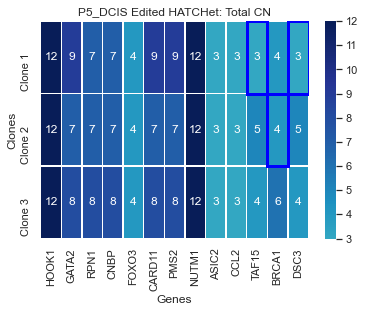

In [27]:
og_dcis_genes = run_plot_genes(unedited_overlapping_bindict, unedited_heatmap_dict, "P5_DCIS", 4)

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
cn_sums [12, 12, 12]
cn_sums [9, 7, 8]
cn_sums [7, 7, 8]
cn_sums [7, 7, 8]
cn_sums [4, 4, 4]
cn_sums [9, 7, 8]
cn_sums [9, 7, 8]
cn_sums [12, 12, 12]
cn_sums [3, 3, 3]
cn_sums [3, 3, 3]
cn_sums [3, 5, 4]
cn_sums [4, 4, 6]
cn_sums [3, 5, 4]
[[12  9  7  7  4  9  9 12  3  3  3  4  3]
 [12  7  7  7  4  7  7 12  3  3  5  4  5]
 [12  8  8  8  4  8  8 12  3  3  4  6  4]]
['Clone 1', 'Clone 2', 'Clone 3']


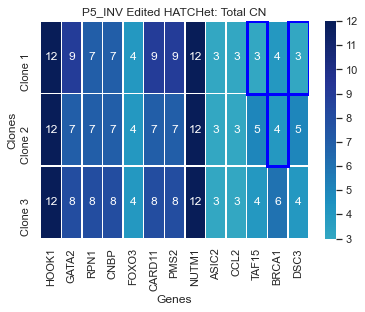

In [29]:
og_inv_genes = run_plot_genes(unedited_overlapping_bindict, unedited_heatmap_dict, "P5_INV", 4)

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
cn_sums [8, 7]
cn_sums [4, 5]
cn_sums [2, 5]
cn_sums [2, 5]
cn_sums [2, 2]
cn_sums [4, 5]
cn_sums [4, 5]
cn_sums [8, 7]
cn_sums [2, 1]
cn_sums [2, 1]
cn_sums [3, 1]
cn_sums [4, 2]
cn_sums [3, 1]
[[8 4 2 2 2 4 4 8 2 2 3 4 3]
 [7 5 5 5 2 5 5 7 1 1 1 2 1]]
['Clone 1', 'Clone 2']


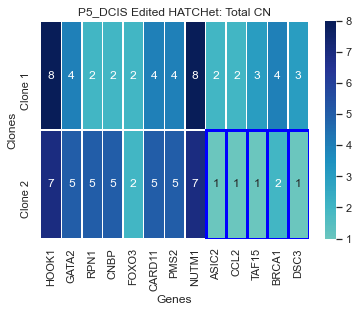

In [30]:
edit_dcis_genes = run_plot_genes(edited_overlapping_bindict, edited_heatmap_dict, "P5_DCIS", 3)

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
cn_sums [8, 7]
cn_sums [4, 5]
cn_sums [2, 5]
cn_sums [2, 5]
cn_sums [2, 2]
cn_sums [4, 5]
cn_sums [4, 5]
cn_sums [8, 7]
cn_sums [2, 1]
cn_sums [2, 1]
cn_sums [3, 1]
cn_sums [4, 2]
cn_sums [3, 1]
[[8 4 2 2 2 4 4 8 2 2 3 4 3]
 [7 5 5 5 2 5 5 7 1 1 1 2 1]]
['Clone 1', 'Clone 2']


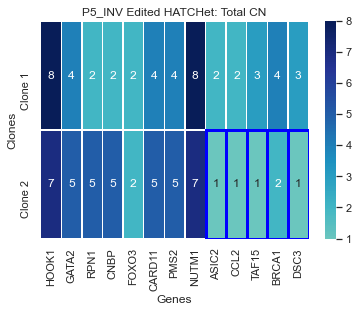

In [31]:
edit_inv_genes = run_plot_genes(edited_overlapping_bindict, edited_heatmap_dict, "P5_INV", 3)

In [32]:
sample = 'P5_INV'

In [33]:
unedited_heatmap_dict

{'P5_DCIS': {'HOOK1': {'total_cn': [12, 12, 12],
   'allele': [['10', '2'], ['8', '4'], ['9', '3']],
   'LOH': [False, False, False]},
  'GATA2': {'total_cn': [9, 7, 8],
   'allele': [['7', '2'], ['2', '5'], ['4', '4']],
   'LOH': [False, False, False]},
  'RPN1': {'total_cn': [7, 7, 8],
   'allele': [['5', '2'], ['5', '2'], ['6', '2']],
   'LOH': [False, False, False]},
  'CNBP': {'total_cn': [7, 7, 8],
   'allele': [['5', '2'], ['5', '2'], ['6', '2']],
   'LOH': [False, False, False]},
  'FOXO3': {'total_cn': [4, 4, 4],
   'allele': [['2', '2'], ['2', '2'], ['2', '2']],
   'LOH': [False, False, False]},
  'CARD11': {'total_cn': [9, 7, 8],
   'allele': [['7', '2'], ['2', '5'], ['4', '4']],
   'LOH': [False, False, False]},
  'PMS2': {'total_cn': [9, 7, 8],
   'allele': [['7', '2'], ['2', '5'], ['4', '4']],
   'LOH': [False, False, False]},
  'NUTM1': {'total_cn': [12, 12, 12],
   'allele': [['10', '2'], ['8', '4'], ['9', '3']],
   'LOH': [False, False, False]},
  'ASIC2': {'total_cn':

In [34]:
unedited_overlapping_bindict

{1: {('HOOK1', 59814786, 59876322): (59750000, 60000000)},
 3: {('GATA2', 128479427, 128493201): (128250000, 128500000),
  ('RPN1', 128619969, 128681075): (128500000, 128750000),
  ('CNBP', 129167827, 129183922): (129000000, 129250000)},
 6: {('FOXO3', 108559835, 108684774): (108500000, 108750000)},
 7: {('CARD11', 2906142, 3043867): (2750000, 3000000),
  ('PMS2', 5970925, 6009106): (5750000, 6000000)},
 8: {},
 15: {('NUTM1', 34343315, 34357737): (34250000, 34500000)},
 17: {('ASIC2', 33013087, 34174964): (33500000, 33750000),
  ('CCL2', 34255218, 34257203): (34250000, 34500000),
  ('TAF15', 35713791, 35864615): (35750000, 36000000),
  ('BRCA1', 43044295, 43170245): (43000000, 43250000)},
 18: {('DSC3', 30989365, 31042815): (30750000, 31000000)}}

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


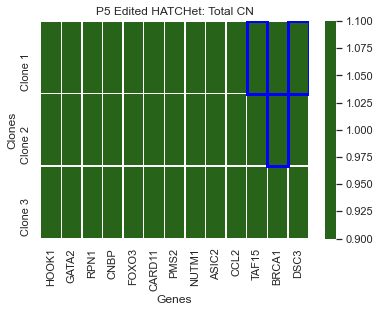

In [48]:
run_plot_summary(unedited_heatmap_dict, 4, unedited_overlapping_bindict, sample)

{1: ['HOOK1'], 3: ['GATA2', 'RPN1', 'CNBP'], 6: ['FOXO3'], 7: ['CARD11', 'PMS2'], 8: [], 15: ['NUTM1'], 17: ['ASIC2', 'CCL2', 'TAF15', 'BRCA1'], 18: ['DSC3']}
[array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]), array([ 1,  1,  1,  1,  0,  1,  1,  1, -1, -1, -1,  0, -1])]


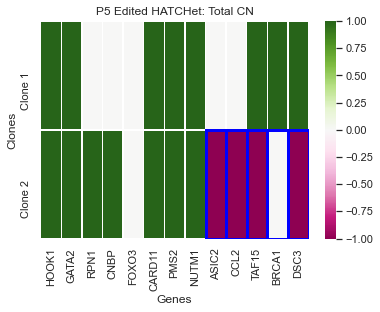

In [49]:
run_plot_summary(edited_heatmap_dict, 3, edited_overlapping_bindict, sample)

In [68]:
sample = "INV"
sncell = [[1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1]  # black line is majority
         ]
edited = [[ 1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  0, -1] 
         ] # c2
original = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
           ]  # c2

    

In [69]:
edited_plot_data = calc_plot_data(sncell, edited, edit_inv_genes)
original_plot_data = calc_plot_data(sncell, original, og_inv_genes)

correct [('amps, amps', 'HOOK1'), ('amps, amps', 'GATA2'), ('amps, amps', 'RPN1'), ('amps, amps', 'CNBP'), ('amps, amps', 'CARD11'), ('amps, amps', 'PMS2'), ('amps, amps', 'NUTM1'), ('dels, dels', 'DSC3')]
incorrect [('dels, neus', 'FOXO3'), ('dels, neus', 'ASIC2'), ('dels, neus', 'CCL2'), ('dels, neus', 'TAF15'), ('dels, neus', 'BRCA1')]
correct [('amps, amps', 'HOOK1'), ('amps, amps', 'GATA2'), ('amps, amps', 'RPN1'), ('amps, amps', 'CNBP'), ('amps, amps', 'CARD11'), ('amps, amps', 'PMS2'), ('amps, amps', 'NUTM1')]
incorrect [('dels, amps', 'FOXO3'), ('dels, amps', 'ASIC2'), ('dels, amps', 'CCL2'), ('dels, amps', 'TAF15'), ('dels, amps', 'BRCA1'), ('dels, amps', 'DSC3')]


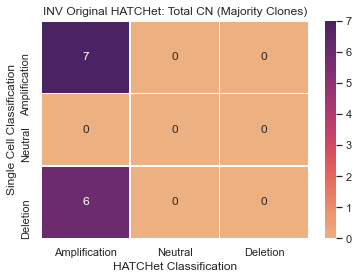

In [70]:
title = "%s Original HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(original_plot_data, title)

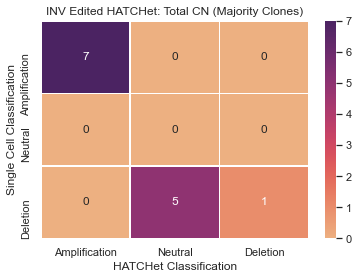

In [71]:
title = "%s Edited HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(edited_plot_data, title)

In [72]:
# write to file
f = "/Users/gillianchu/mek/cnaviz/genes/summary/P5_INV_hatchet.txt"
with open(f, "w+") as w:
    w.write(str(original_plot_data) + "\n")
    w.write(str(edited_plot_data) + "\n")

In [73]:
sample = 'DCIS'

sncell = [[1, 1, 1, 1, 0, 1, 1, 0, -1, -1, -1, -1, -1] # blue
         ]
edited = [[ 1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  0, -1] # only clone
         ]
original = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
           ]  # had three clones, took major clone prop (clone 1)


In [74]:
edited_plot_data = calc_plot_data(sncell, edited, edit_dcis_genes)
original_plot_data = calc_plot_data(sncell, original, og_dcis_genes)

correct [('amps, amps', 'HOOK1'), ('amps, amps', 'GATA2'), ('amps, amps', 'RPN1'), ('amps, amps', 'CNBP'), ('neus, neus', 'FOXO3'), ('amps, amps', 'CARD11'), ('amps, amps', 'PMS2'), ('dels, dels', 'DSC3')]
incorrect [('neus, amps', 'NUTM1'), ('dels, neus', 'ASIC2'), ('dels, neus', 'CCL2'), ('dels, neus', 'TAF15'), ('dels, neus', 'BRCA1')]
correct [('amps, amps', 'HOOK1'), ('amps, amps', 'GATA2'), ('amps, amps', 'RPN1'), ('amps, amps', 'CNBP'), ('amps, amps', 'CARD11'), ('amps, amps', 'PMS2')]
incorrect [('neus, amps', 'FOXO3'), ('neus, amps', 'NUTM1'), ('dels, amps', 'ASIC2'), ('dels, amps', 'CCL2'), ('dels, amps', 'TAF15'), ('dels, amps', 'BRCA1'), ('dels, amps', 'DSC3')]


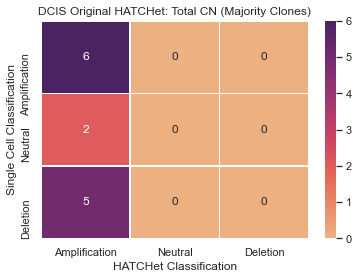

In [75]:
title = "%s Original HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(original_plot_data, title)

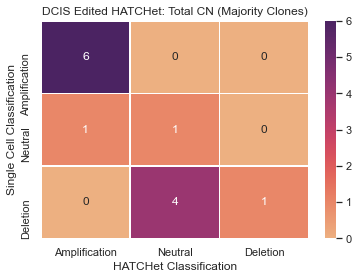

In [76]:
title = "%s Edited HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(edited_plot_data, title)

In [77]:
# write to file
f = "/Users/gillianchu/mek/cnaviz/genes/summary/P5_DCIS_hatchet.txt"
with open(f, "w+") as w:
    w.write(str(original_plot_data) + "\n")
    w.write(str(edited_plot_data) + "\n")

In [78]:
data.genes_by_name("FOXO3")

[Gene(gene_id='ENSG00000118689', gene_name='FOXO3', biotype='protein_coding', contig='6', start=108559835, end=108684774, strand='+', genome='GRCh38')]

In [79]:
data.genes_by_name("DSC3")

[Gene(gene_id='ENSG00000134762', gene_name='DSC3', biotype='protein_coding', contig='18', start=30989365, end=31042815, strand='-', genome='GRCh38')]